In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
import tensorflow as tf
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.layers import concatenate
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install kaggle
!mkdir .kaggle
!mv kaggle.json .kaggle
!mv .kaggle /root/

!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 194M/195M [00:09<00:00, 24.6MB/s]
100% 195M/195M [00:09<00:00, 21.7MB/s]


In [3]:
with zipfile.ZipFile('/content/breast-ultrasound-images-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [5]:
DATA_DIR = "/content/Dataset_BUSI_with_GT"

In [3]:
classes = ['benign', 'malignant', 'normal']

In [6]:
folders = os.listdir(DATA_DIR)
names = []
file_names = []
mask_names = []
labels = []
for folder in folders:
  for files in os.listdir(os.path.join(DATA_DIR, folder)):
    names.append(files.split(')')[0])
    labels.append(folder)

for i in range(len(names)):
  file_names.append(os.path.join(DATA_DIR, labels[i], names[i]) + ').png')
  mask_names.append(os.path.join(DATA_DIR, labels[i], names[i]) + ')_mask.png')


In [7]:
df = pd.DataFrame({'image': file_names,
                   'mask': mask_names,
                   'label': labels}, 
                  columns=['image', 'mask', 'label']).sample(frac = 1, random_state=1).reset_index(drop=True)
df.head()

,image,mask,label
0,/content/Dataset_BUSI_with_GT/benign/benign (7...,/content/Dataset_BUSI_with_GT/benign/benign (7...,benign
1,/content/Dataset_BUSI_with_GT/malignant/malign...,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
2,/content/Dataset_BUSI_with_GT/benign/benign (1...,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
3,/content/Dataset_BUSI_with_GT/malignant/malign...,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
4,/content/Dataset_BUSI_with_GT/malignant/malign...,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant


In [8]:
df.drop_duplicates(subset=['image', 'mask', 'label'], keep='first', inplace=True)
df.head()

,image,mask,label
0,/content/Dataset_BUSI_with_GT/benign/benign (7...,/content/Dataset_BUSI_with_GT/benign/benign (7...,benign
1,/content/Dataset_BUSI_with_GT/malignant/malign...,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
2,/content/Dataset_BUSI_with_GT/benign/benign (1...,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
3,/content/Dataset_BUSI_with_GT/malignant/malign...,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
4,/content/Dataset_BUSI_with_GT/malignant/malign...,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant


In [20]:
print(f"There {df.shape[0]} images in this dataset")

There 780 images in this dataset


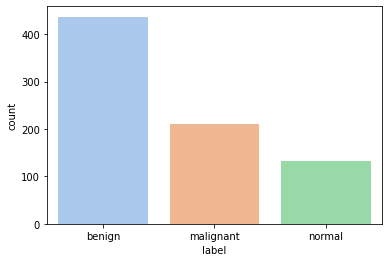

In [14]:
sns.countplot(x=df["label"], palette='pastel')

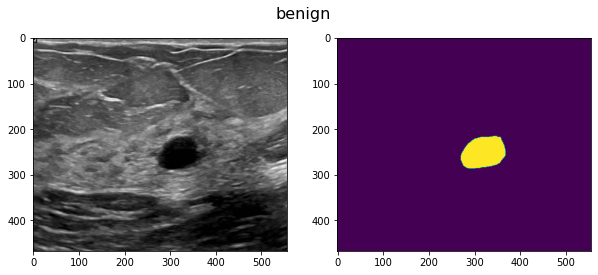

In [18]:
index = 8

plt.figure(figsize=(10,4))
plt.suptitle(df.iloc[index]['label'], fontsize=16)
plt.subplot(1,2,1)
plt.imshow(plt.imread(df.iloc[index]['image']))
plt.subplot(1,2,2)
plt.imshow(plt.imread(df.iloc[index]['mask']))
plt.show()

In [19]:
exclude_normal = df[df['label'] != 'normal']
shape = 256
images_path = list(exclude_normal['image'])
masks_path = list(exclude_normal['mask'])
images = np.zeros((647, shape, shape, 3))
masks = np.zeros((647, shape, shape))

for i in range(len(images_path)):
  img = plt.imread(images_path[i])
  img_resized = cv2.resize(img,(shape,shape))
  images[i] = img_resized

  mask = plt.imread(masks_path[i])
  mask_resized = cv2.resize(mask,(shape,shape))
  masks[i] = mask_resized

In [23]:
print(f"The shape of images (except normal ones): {images.shape}")
print(f"The shape of masks (except normal ones): {masks.shape}")

The shape of images (except normal ones): (647, 256, 256, 3)
The shape of masks (except normal ones): (647, 256, 256)


In [ ]:
# images = images/255
# masks = masks/255
# masks[masks > 1.0] = 1.0

In [26]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.2, random_state = 3)

In [28]:
def dice_coefficient(y_true, y_pred, axis=(1, 2), epsilon=0.00001):
    dice_numerator = 2 * tf.keras.backend.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = tf.keras.backend.sum(y_true, axis=axis) + tf.keras.backend.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = tf.keras.backend.mean(dice_numerator/dice_denominator)

    return dice_coefficient

def soft_dice_loss(y_true, y_pred, axis=(1, 2), epsilon=0.00001):
    dice_numerator = 2 * tf.keras.backend.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = tf.keras.backend.sum(y_true ** 2, axis=axis) + tf.keras.backend.sum(y_pred ** 2, axis=axis) + epsilon
    dice_loss = 1 - tf.keras.backend.mean(dice_numerator/dice_denominator)
    return dice_loss

In [30]:
def create_convolution_block(input_layer, n_filters, batch_normalization=True,
                             kernel=(3, 3),padding='same', strides=(1, 1),
                             instance_normalization=False):
    layer = Conv2D(n_filters, kernel, padding=padding,kernel_initializer = 'he_normal', strides=strides)(input_layer)
    if batch_normalization:
      layer = BatchNormalization()(layer)
    return Activation('relu')(layer)

In [32]:
dropout = 0.2
numFilters = 32
doBatchNorm = True

In [33]:
input_layer = Input(shape=(shape, shape, 3))
down_depth_0_layer_0 = create_convolution_block(input_layer, numFilters * 1, kernel = (3,3))
down_depth_0_layer_1 = create_convolution_block(down_depth_0_layer_0, numFilters * 2, kernel = (3,3))
down_depth_0_layer_pool = MaxPooling2D(pool_size=(2,2))(down_depth_0_layer_1)
down_depth_0_layer_drop = Dropout(dropout)(down_depth_0_layer_pool)

down_depth_1_layer_0 = create_convolution_block(down_depth_0_layer_drop, numFilters * 2, kernel = (3,3))
down_depth_1_layer_1 = create_convolution_block(down_depth_1_layer_0, numFilters * 4, kernel = (3,3))
down_depth_2_layer_pool = MaxPooling2D(pool_size=(2,2))(down_depth_1_layer_1)
down_depth_1_layer_drop = Dropout(dropout)(down_depth_2_layer_pool)

down_depth_2_layer_0 = create_convolution_block(down_depth_1_layer_drop, numFilters * 4, kernel = (3,3))
down_depth_2_layer_1 = create_convolution_block(down_depth_2_layer_0, numFilters * 8, kernel = (3,3))
down_depth_2_layer_pool = MaxPooling2D(pool_size=(2,2))(down_depth_2_layer_1)
down_depth_2_layer_drop = Dropout(dropout)(down_depth_2_layer_pool)


depth_2_layer_0 = create_convolution_block(down_depth_2_layer_drop, numFilters * 8, kernel = (3,3))


up_depth_2_layer_0 = Conv2DTranspose(32 * 4, kernel_size=(3,3), strides=(2,2), padding='same')(depth_2_layer_0)
up_depth_2_concat = concatenate([up_depth_2_layer_0,down_depth_2_layer_1])
up_depth_1_layer_drop = Dropout(dropout)(up_depth_2_concat)
down_depth_2_layer_0 = create_convolution_block(up_depth_1_layer_drop, numFilters * 8, kernel = (3,3))
down_depth_2_layer_1 = create_convolution_block(down_depth_2_layer_0, numFilters * 4, kernel = (3,3))

up_depth_1_layer_0 = Conv2DTranspose(32 * 2, kernel_size=(3,3), strides=(2,2), padding='same')(down_depth_2_layer_1)
up_depth_1_concat = concatenate([up_depth_1_layer_0,down_depth_1_layer_1])
up_depth_1_layer_drop = Dropout(dropout)(up_depth_1_concat)
down_depth_1_layer_0 = create_convolution_block(up_depth_1_layer_drop, numFilters * 4, kernel = (3,3))
down_depth_1_layer_1 = create_convolution_block(down_depth_1_layer_0, numFilters * 2, kernel = (3,3))

up_depth_0_layer_0 = Conv2DTranspose(32 * 1, kernel_size=(3,3), strides=(2,2), padding='same')(down_depth_1_layer_1)
up_depth_0_concat = concatenate([up_depth_0_layer_0,down_depth_0_layer_1])
up_depth_0_layer_drop = Dropout(dropout)(up_depth_0_concat)
down_depth_0_layer_0 = create_convolution_block(up_depth_0_layer_drop, numFilters * 2, kernel = (3,3))
down_depth_0_layer_1 = create_convolution_block(down_depth_0_layer_0, numFilters * 1, kernel = (3,3))

final_conv = Conv2D(filters=1,kernel_size=(1,1))(down_depth_0_layer_1)
final_activation = Activation('sigmoid')(final_conv)

model = Model(inputs=input_layer, outputs=final_activation)
model.compile(optimizer= tf.keras.optimizers.Adam(lr=0.001), loss=soft_dice_loss ,metrics=[dice_coefficient, 'accuracy'])

In [35]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
17/17 [==============================] - 20s 1s/step - loss: 0.5361 - dice_coefficient: 0.2754 - accuracy: 0.9002 - val_loss: 0.8282 - val_dice_coefficient: 0.1901 - val_accuracy: 0.1523
Epoch 2/50
17/17 [==============================] - 20s 1s/step - loss: 0.4854 - dice_coefficient: 0.2956 - accuracy: 0.9146 - val_loss: 0.8243 - val_dice_coefficient: 0.1925 - val_accuracy: 0.1800
Epoch 3/50
17/17 [==============================] - 20s 1s/step - loss: 0.4501 - dice_coefficient: 0.3316 - accuracy: 0.9208 - val_loss: 0.7674 - val_dice_coefficient: 0.2284 - val_accuracy: 0.5186
Epoch 4/50
17/17 [==============================] - 20s 1s/step - loss: 0.4299 - dice_coefficient: 0.3510 - accuracy: 0.9230 - val_loss: 0.7356 - val_dice_coefficient: 0.2515 - val_accuracy: 0.5130
Epoch 5/50
17/17 [==============================] - 20s 1s/step - loss: 0.4085 - dice_coefficient: 0.3715 - accuracy: 0.9270 - val_loss: 0.6599 - val_dice_coefficient: 0.2977 - val_accuracy: 0.7186
Epoch 6/50

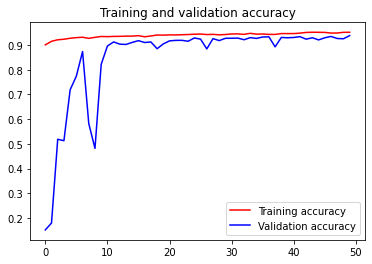

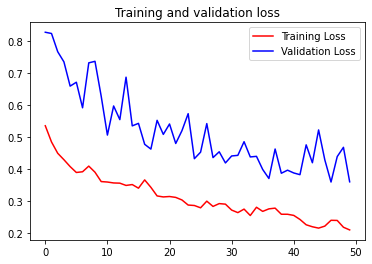

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
y_predicted = model.predict(np.array(X_test))
y_predicted.shape

5/5 [==============================] - 2s 311ms/step


(130, 256, 256, 1)

In [48]:
threshold = 0.5

y_predicted[y_predicted > threshold] = 1.0
y_predicted[y_predicted <= threshold] = 0.0

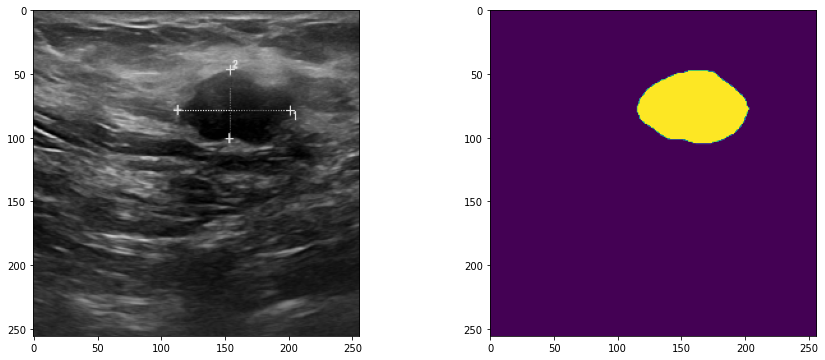

In [60]:
index = 40
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow(X_test[index])
plt.subplot(1,2,2)
plt.imshow(y_test[index])

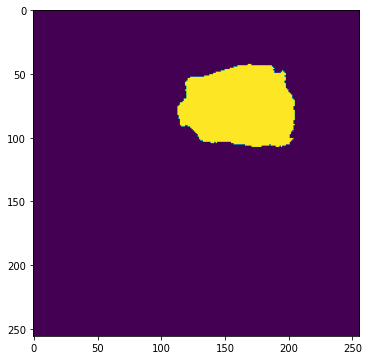

In [61]:
plt.figure(figsize=(15,6))
plt.imshow(y_predicted[index][:, :, 0])

In [62]:
model.save('breast.h5')

In [69]:
def compute_class_sens_spec(pred, label, class_num):
    class_pred = pred[class_num]
    class_label = label[class_num]
    tp = np.sum( (class_pred == 1) * (class_label == 1))
    tn = np.sum( (class_pred == 0) * (class_label == 0))
    fp = np.sum( (class_pred == 1) * (class_label == 0))
    fn = np.sum( (class_pred == 0) * (class_label == 1))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return sensitivity, specificity

In [70]:
compute_class_sens_spec(y_predicted, y_test, 3)

(0.19745949074074073, 0.9104303728070176)

In [71]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['benign', 'malignant'], 
        index = ['Sensitivity','Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [72]:
get_sens_spec_df(y_predicted, y_test)

,benign,malignant
Sensitivity,0.1679,0.0544
Specificity,0.8924,0.9719
